Using device: mps
Comparing variance reduction techniques...

--- Running seed 1/3 ---

Training Basic REINFORCE...
Episode 100, Avg reward: 23.15, Grad variance: 50.7047, Return variance: 0.0000
Episode 200, Avg reward: 25.75, Grad variance: 96.1498, Return variance: 0.0000
Episode 300, Avg reward: 11.88, Grad variance: 31.7528, Return variance: 0.0000
Episode 400, Avg reward: 20.06, Grad variance: 105.7882, Return variance: 0.0000
Episode 500, Avg reward: 49.97, Grad variance: 421.7860, Return variance: 0.0000

Training REINFORCE + Standardized Returns...
Episode 100, Avg reward: 10.89, Grad variance: 0.0210, Return variance: 0.0000
Episode 200, Avg reward: 9.35, Grad variance: 0.0000, Return variance: 0.0000
Episode 300, Avg reward: 9.39, Grad variance: 0.0000, Return variance: 0.0000
Episode 400, Avg reward: 9.49, Grad variance: 0.0242, Return variance: 0.0000
Episode 500, Avg reward: 9.31, Grad variance: 0.0000, Return variance: 0.0000

Training REINFORCE + Reward-to-Go...
Episode

OSError: [Errno 30] Read-only file system: '/variance_reduction_comparison.png'

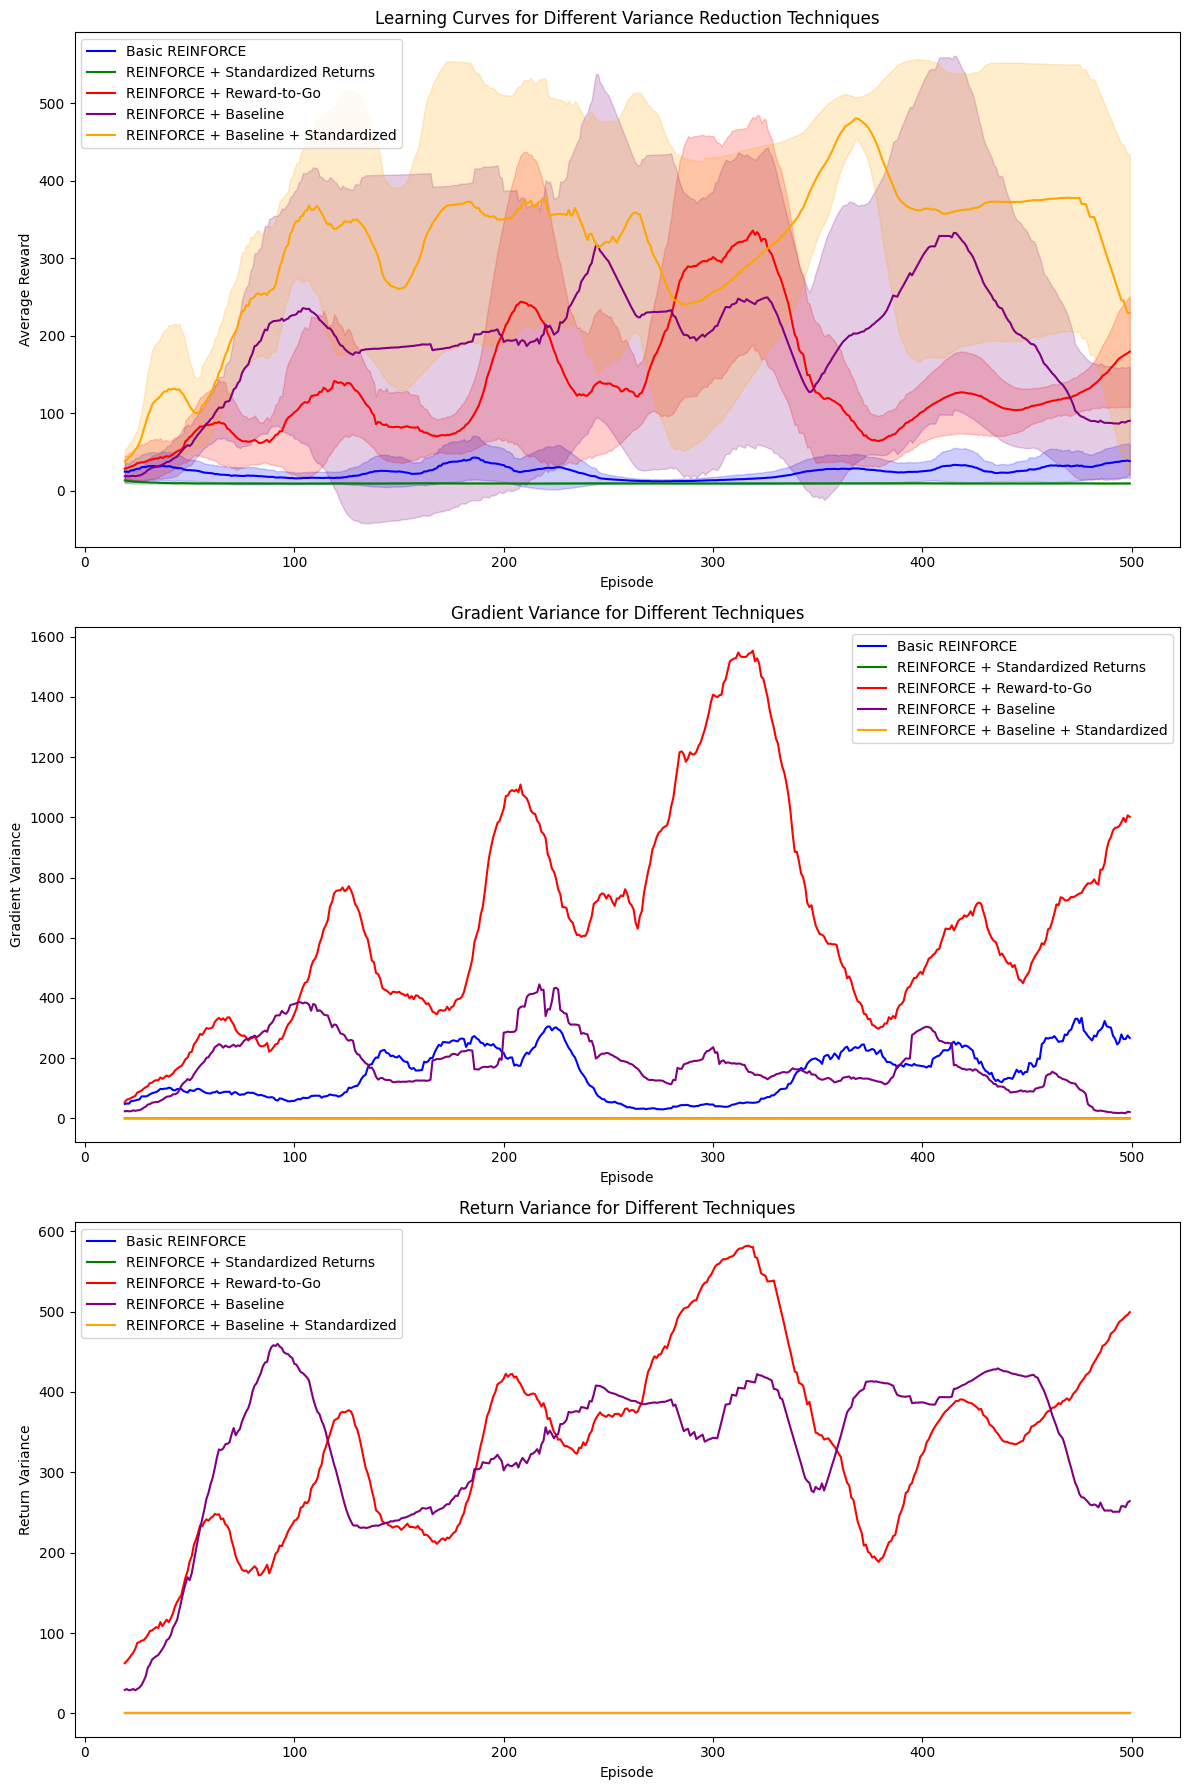

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque

# Check if MPS is available (for Mac with Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

class Policy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Policy, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
        self.to(device)
    
    def forward(self, x):
        return self.network(x)
    
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.to(device)
    
    def forward(self, x):
        return self.network(x)

class REINFORCEVarianceAnalysis:
    def __init__(self, env, learning_rate=0.01, gamma=0.99, use_baseline=False, 
                 standardize_returns=False, use_reward_to_go=True):
    
        self.env = env
        self.gamma = gamma
        self.use_baseline = use_baseline
        self.standardize_returns = standardize_returns
        self.use_reward_to_go = use_reward_to_go
        
        # Get input dimension
        if isinstance(env.observation_space, gym.spaces.Discrete):
            self.input_dim = env.observation_space.n
        else:
            self.input_dim = env.observation_space.shape[0]
            
        # Create policy network
        self.policy = Policy(self.input_dim, env.action_space.n)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        # Create value network (for baseline)
        if use_baseline:
            self.value = ValueNetwork(self.input_dim)
            self.value_optimizer = optim.Adam(self.value.parameters(), lr=learning_rate)
        
        # For tracking variance
        self.grad_variance_history = []
        self.return_variance_history = []
        
    def collect_trajectory(self):
        """Collect a trajectory and store states, actions, rewards and log probs"""
        state = self.env.reset()
        if isinstance(state, tuple):
            state = state[0]
            
        done = False
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        episode_reward = 0

        step_count = 0
        max_steps = 500
    
        
        while not done and step_count < max_steps:
            # Store state
            self.states.append(state)
            
            # Sample action
            action, log_prob = self.policy.act(state)
            
            # Take action in environment
            next_state, reward, done, *_ = self.env.step(action)
            if len(_) > 0:
                if isinstance(_, tuple) and len(_) > 0 and isinstance(_[0], dict):
                    truncated = _[0].get('truncated', False)
                    done = done or truncated
                    
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            
            # Store action, reward, log_prob
            self.actions.append(action)
            self.rewards.append(reward)
            self.log_probs.append(log_prob)
            
            # Update state and episode reward
            state = next_state
            episode_reward += reward
            step_count += 1
            
            if done:
                break
                
        return episode_reward
    
    def compute_returns(self):
        T = len(self.rewards)
        
        # Convert rewards to tensor and move to device
        rewards_tensor = torch.FloatTensor(self.rewards).to(device)
        
        if self.use_reward_to_go:
            # Vectorized reward-to-go computation
            returns = torch.zeros_like(rewards_tensor)
            future_return = 0
            
            for t in reversed(range(T)):
                future_return = rewards_tensor[t] + self.gamma * future_return
                returns[t] = future_return
        else:
            # Compute full episode return (same for all steps)
            G = 0
            for t in reversed(range(T)):
                G = self.rewards[t] + self.gamma * G
            returns = torch.full((T,), G, device=device, dtype=torch.float32)
        
        # Standardize returns (if enabled)
        if self.standardize_returns and T > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            
        return returns
    
    def compute_value_baseline(self):
        # Convert states to tensor and move to device
        states = torch.FloatTensor(np.array(self.states)).to(device)
        return self.value(states).squeeze()
    
    def update_policy(self):
    
        # Check if we have any data to update from
        if len(self.rewards) == 0:
            return
        
        # Compute returns
        returns = self.compute_returns()
        
        # Calculate baseline (if enabled)
        if self.use_baseline:
            baseline = self.compute_value_baseline()
            advantage = returns - baseline.detach()  # Detach to prevent gradient flow
            
            # Update value function
            value_loss = nn.MSELoss()(baseline, returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
        else:
            advantage = returns
        
        # Calculate policy loss using vectorized operations
        self.policy_optimizer.zero_grad()
        
        # Stack log probs for batch computation
        log_probs_tensor = torch.stack(self.log_probs)
        
        # Compute policy loss in one go
        policy_loss = -(log_probs_tensor * advantage).sum()
        
        # Store individual terms for variance analysis
        policy_grads = (-log_probs_tensor * advantage).detach().cpu().numpy()
        
        # Backward pass
        policy_loss.backward()
        
        # Track variance before optimization
        grad_variance = np.var(policy_grads) if len(policy_grads) > 1 else 0
        return_variance = returns.cpu().var().item() if len(returns) > 1 else 0
        
        self.grad_variance_history.append(grad_variance)
        self.return_variance_history.append(return_variance)
        
        # Update policy weights
        self.policy_optimizer.step()
    
    def train(self, num_episodes=1000, print_every=100):
        """Train agent and collect statistics for variance analysis"""
        reward_history = []
        avg_rewards = deque(maxlen=print_every)
        
        for episode in range(1, num_episodes + 1):
            # Collect trajectory
            episode_reward = self.collect_trajectory()
            reward_history.append(episode_reward)
            avg_rewards.append(episode_reward)
            
            # Update policy
            self.update_policy()
            
            # Print progress
            if episode % print_every == 0:
                avg_reward = np.mean(avg_rewards)
                avg_grad_var = np.mean(self.grad_variance_history[-print_every:])
                avg_return_var = np.mean(self.return_variance_history[-print_every:])
                print(f"Episode {episode}, Avg reward: {avg_reward:.2f}, " 
                      f"Grad variance: {avg_grad_var:.4f}, Return variance: {avg_return_var:.4f}")
                
        return reward_history
    
    def plot_variance_analysis(self):
        """Plot reward and variance metrics for analysis"""
        smoothing_window = 100
        
        # Setup plots
        fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
        
        # Plot reward
        x = range(1, len(self.grad_variance_history) + 1)
        y = self.grad_variance_history
        y_smooth = np.convolve(y, np.ones(smoothing_window)/smoothing_window, mode='valid')
        axs[0].plot(x, y, alpha=0.3, color='blue')
        axs[0].plot(range(smoothing_window, len(y) + 1), y_smooth, color='blue')
        axs[0].set_title('Gradient Variance Over Time')
        axs[0].set_ylabel('Variance')
        
        # Plot gradient variance
        y = self.return_variance_history
        y_smooth = np.convolve(y, np.ones(smoothing_window)/smoothing_window, mode='valid')
        axs[1].plot(x, y, alpha=0.3, color='green')
        axs[1].plot(range(smoothing_window, len(y) + 1), y_smooth, color='green')
        axs[1].set_title('Return Variance Over Time')
        axs[1].set_ylabel('Variance')
        
        # Plot correlation between variance and learning
        axs[2].scatter(self.return_variance_history, self.grad_variance_history, alpha=0.5)
        axs[2].set_title('Correlation: Return Variance vs. Gradient Variance')
        axs[2].set_xlabel('Return Variance')
        axs[2].set_ylabel('Gradient Variance')
        
        plt.tight_layout()
        return fig

# Function to compare different variance reduction techniques
def compare_variance_reduction_techniques(env_name="CartPole-v1", num_episodes=500, num_seeds=3):
    """
    Compare different variance reduction techniques for REINFORCE
    
    Args:
        env_name: Gym environment name
        num_episodes: Number of episodes to train for
        num_seeds: Number of random seeds to run
        
    Returns:
        Dictionary of results for each method
    """
    # Configuration for different techniques
    configurations = {
        'Basic REINFORCE': {
            'use_baseline': False,
            'standardize_returns': False,
            'use_reward_to_go': False
        },
        'REINFORCE + Standardized Returns': {
            'use_baseline': False,
            'standardize_returns': True,
            'use_reward_to_go': False
        },
        'REINFORCE + Reward-to-Go': {
            'use_baseline': False,
            'standardize_returns': False,
            'use_reward_to_go': True
        },
        'REINFORCE + Baseline': {
            'use_baseline': True,
            'standardize_returns': False,
            'use_reward_to_go': True
        },
        'REINFORCE + Baseline + Standardized': {
            'use_baseline': True,
            'standardize_returns': True,
            'use_reward_to_go': True
        }
    }
    
    results = {method: [] for method in configurations}
    
    # Run each method with multiple seeds
    for seed in range(num_seeds):
        print(f"\n--- Running seed {seed+1}/{num_seeds} ---")
        
        for method, config in configurations.items():
            print(f"\nTraining {method}...")
            
            # Set seeds for reproducibility
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.backends.mps.is_available():
                torch.mps.manual_seed(seed)
            elif torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
            
            # Create environment
            try:
                env = gym.make(env_name)
            except:
                # Fallback for newer gym versions
                import gymnasium as gym
                env = gym.make(env_name)
                
            # Create agent with specific configuration
            agent = REINFORCEVarianceAnalysis(
                env=env,
                learning_rate=0.01,
                gamma=0.99,
                **config
            )
            
            # Train agent
            reward_history = agent.train(num_episodes=num_episodes, print_every=100)
            
            # Store results
            results[method].append({
                'rewards': reward_history,
                'grad_variance': agent.grad_variance_history,
                'return_variance': agent.return_variance_history
            })
            
            env.close()
    
    # Plot comparison
    plot_comparison(results, num_seeds, num_episodes)
    
    return results

def plot_comparison(results, num_seeds, num_episodes):
    """Plot comparison of different variance reduction techniques"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Smoothing window
    window = 20
    
    # Colors for different methods
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    
    # Plot rewards
    for i, (method, method_results) in enumerate(results.items()):
        all_rewards = [result['rewards'] for result in method_results]
        mean_rewards = np.mean(all_rewards, axis=0)
        std_rewards = np.std(all_rewards, axis=0)
        
        # Smooth the mean rewards
        mean_smooth = np.convolve(mean_rewards, np.ones(window)/window, mode='valid')
        x = range(window-1, num_episodes)
        
        # Plot mean and std
        ax1.plot(x, mean_smooth, label=method, color=colors[i % len(colors)])
        ax1.fill_between(
            x, 
            np.convolve(mean_rewards - std_rewards, np.ones(window)/window, mode='valid'),
            np.convolve(mean_rewards + std_rewards, np.ones(window)/window, mode='valid'),
            alpha=0.2, color=colors[i % len(colors)]
        )
    
    ax1.set_title('Learning Curves for Different Variance Reduction Techniques')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward')
    ax1.legend()
    
    # Plot gradient variance
    for i, (method, method_results) in enumerate(results.items()):
        all_grad_vars = [result['grad_variance'] for result in method_results]
        mean_grad_vars = np.mean(all_grad_vars, axis=0)
        
        # Smooth the mean gradient variance
        mean_smooth = np.convolve(mean_grad_vars, np.ones(window)/window, mode='valid')
        x = range(window-1, num_episodes)
        
        ax2.plot(x, mean_smooth, label=method, color=colors[i % len(colors)])
    
    ax2.set_title('Gradient Variance for Different Techniques')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Gradient Variance')
    ax2.legend()
    
    # Plot return variance
    for i, (method, method_results) in enumerate(results.items()):
        all_return_vars = [result['return_variance'] for result in method_results]
        mean_return_vars = np.mean(all_return_vars, axis=0)
        
        # Smooth the mean return variance
        mean_smooth = np.convolve(mean_return_vars, np.ones(window)/window, mode='valid')
        x = range(window-1, num_episodes)
        
        ax3.plot(x, mean_smooth, label=method, color=colors[i % len(colors)])
    
    ax3.set_title('Return Variance for Different Techniques')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Return Variance')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig('variance_reduction_comparison.png')
    plt.show()

# Run the comparison if executed directly
if __name__ == "__main__":
    # Set seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(42)
    elif torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    print("Comparing variance reduction techniques...")
    results = compare_variance_reduction_techniques(
        env_name="CartPole-v1", 
        num_episodes=500,
        num_seeds=3
    )
    
    print("\nDone! Check the saved plots for analysis.")